# Modules to be imported

In [48]:
import re
import overpy
import psycopg2
import statistics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import csv

# Working with the extracted data

In [5]:
#set option to see all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#open csv file from extracted immo entries
immos = []
with open('immo.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        print(' '.join(row).split(','))
        immos.append(' '.join(row))

['"(\'4.5 rooms', ' 112 m²', " CHF 3970.—'", " 'Ernst-Jung-Gasse 18", ' 8400 Winterthur', ' ZH\')"', '"(\'3.5 rooms', ' 96 m²', " CHF 1755.—'", " 'Römerstr. 152", ' 8404 Winterthur', ' ZH\')"', '"(\'3 rooms', ' 65 m²', " CHF 1480.—'", " 'Strahleggstrasse 68", ' 8400 Winterthur', ' ZH\')"', '"(\'3.5 rooms', ' 83 m²', " CHF 1920.—'", " 'Hegistr. 35d", ' 8404 Winterthur', ' ZH\')"', '"(\'2.5 rooms', ' 55 m²', " CHF 1770.—'", " 'Wülflingerstrasse 155", ' 8408 Winterthur', ' ZH\')"', '"(\'4.5 rooms', ' 105 m²', " CHF 1873.—'", " 'Landvogt-Waser-Strasse 33", ' 8405 Winterthur', ' ZH\')"', '"(\'1 room', ' 26 m²', " CHF 1195.—'", " 'Wartstr. 28", ' 8400 Winterthur', ' ZH\')"', '"(\'4.5 rooms', ' 171 m²', " CHF 3339.—'", " 'Stadthausstrasse 12", ' 8400 Winterthur', ' ZH\')"', '"(\'6.5 rooms', ' 200 m²', " CHF 4450.—'", " 'Schlosshofstrasse 218", ' 8404 Winterthur', ' ZH\')"', '"(\'3.5 rooms', ' 103 m²', " CHF 2420.—'", " 'Eichgutstr. 4", ' 8400 Winterthur', ' ZH\')"', '"(\'3 rooms', ' 70 m²', "

In [6]:
#create new dataframe and insert all the results
df = pd.DataFrame()
#do some string transformations and split the string into separate values
for i in immos:
    i = i.replace('"','').replace('\'','')
    i = re.split(r'[()]', i)
    i = [x for x in i if not(x=='' or x==',')]
    df1 = pd.DataFrame(i)
    df1 = df1[0].str.split(',', expand=True)
    df = pd.concat([df,df1])
   

In [7]:
#initial dataframe length without filters
len(df)

4786

In [8]:
# get only the data which has m^2 information
df = df[df[1].str.contains('m²')==True]
df = df.reset_index(inplace=False, drop=True)
df.head()

,0,1,2,3,4,5,6,7,8
0,4.5 rooms,112 m²,CHF 3970.—,Ernst-Jung-Gasse 18,8400 Winterthur,ZH,None,None,NaN
1,3.5 rooms,96 m²,CHF 1755.—,Römerstr. 152,8404 Winterthur,ZH,None,None,NaN
2,3 rooms,65 m²,CHF 1480.—,Strahleggstrasse 68,8400 Winterthur,ZH,None,None,NaN
3,3.5 rooms,83 m²,CHF 1920.—,Hegistr. 35d,8404 Winterthur,ZH,None,None,NaN
4,2.5 rooms,55 m²,CHF 1770.—,Wülflingerstrasse 155,8408 Winterthur,ZH,None,None,NaN


In [9]:
len(df)

3858

In [10]:
df = df.where(pd.notnull(df), None)

for i, rows in df.iterrows():
    #print(print(rows[4]))
    if(rows[4] is not None):
        if(re.match("[A-Z]{2}$",rows[4].lstrip())):
            #print(i)
            df[5][i] = df[4][i].lstrip()
        if(re.search(r"^\d{4}",rows[3].lstrip())):
            #print(i)
            df[4][i] = df[3][i].lstrip()
            df[3][i] = 'nicht vorhanden'
        if(re.search(r"\.\—",df[3][i])):
                if(re.search(r"^\d{4}",rows[4].lstrip())):
                    df[2][i] = df[2][i]+(df[3][i].lstrip())
                    df[3][i] = 'nicht vorhanden'
                    #print(i)
                elif(re.search(r"^\d{4}",rows[5].lstrip())):
                    df[2][i] = df[2][i]+(df[3][i].lstrip())
                    df[3][i] = df[4][i].lstrip()
                    df[4][i] = df[5][i].lstrip()
                    df[5][i] = df[6][i].lstrip()
                    df[6][i] = None
                    #df[3][i] = 'nicht vorhanden'

        if (rows[6] is not None):
            if(re.match("[A-Z]{2}$",rows[6].lstrip())):
                #print(i)
                df[4][i] = df[5][i].lstrip()
                df[5][i] = df[6][i].lstrip()
                df[6][i] = None
            elif(re.match(r"^\d{4}",rows[6].lstrip())):
                df[4][i] = df[6][i].lstrip()
                df[5][i] = df[7][i].lstrip()
                df[6][i] = None
                df[7][i] = None
                #print(df.iloc[i])
            elif(re.match(r"^\d{4}",rows[7].lstrip())):
                #df[5][i] = df[6][i].lstrip()
                df[4][i] = df[7][i].lstrip()
                df[5][i] = df[8][i].lstrip()
                df[6][i] = None
                df[7][i] = None
                df[8][i] = None
#   

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8
0,4.5 rooms,112 m²,CHF 3970.—,Ernst-Jung-Gasse 18,8400 Winterthur,ZH,None,None,None
1,3.5 rooms,96 m²,CHF 1755.—,Römerstr. 152,8404 Winterthur,ZH,None,None,None
2,3 rooms,65 m²,CHF 1480.—,Strahleggstrasse 68,8400 Winterthur,ZH,None,None,None
3,3.5 rooms,83 m²,CHF 1920.—,Hegistr. 35d,8404 Winterthur,ZH,None,None,None
4,2.5 rooms,55 m²,CHF 1770.—,Wülflingerstrasse 155,8408 Winterthur,ZH,None,None,None


In [12]:
#check if every row has a zip code
import math
for i, rows in df.iterrows():
    if(rows[4] is  None):
        print(i)
        continue


1269
1829
1880
2281
2385
2515
3614


In [13]:
#manual data extension with the help of google
df.loc[1269][4] = '4052 Basel'
df.loc[1269][5] = 'BS'
df.loc[1829][4] = '4051 Basel'
df.loc[1829][5] = 'BS'
df = df.drop([1880])
df.loc[2261][4] = '1005 Lausanne'
df.loc[2281][4] = '1018 Lausanne'
df.loc[2281][5] = 'VD'
df.loc[2385][4] = '3013 Bern'
df.loc[2385][5] = 'BE'
df.loc[2515][4] = '3007 Bern'
df.loc[2515][5] = 'BE'
df.loc[3397][4] = '6992 Lugano'
df.loc[3614][4] = '2503 Biel/Bienne'
df.loc[3614][5] = 'BE'


In [14]:
df = df.drop(columns=[6,7,8])

In [15]:
# get only the data which has room information
df = df[df[0].str.contains('room')==True]
len(df)

3857

In [16]:
# get only the data which has correct price information
df = df[df[2].str.contains('CHF')==True]
len(df)

3821

In [17]:
#split rooms into number and word
df[0] = df[0].str.split()
df[1] = df[1].str.split()
df[2] = df[2].str.split()
df[4] = df[4].str.split()
df[6] = df[5]

In [18]:
df.head()

,0,1,2,3,4,5,6
0,"[4.5, rooms]","[112, m²]","[CHF, 3970.—]",Ernst-Jung-Gasse 18,"[8400, Winterthur]",ZH,ZH
1,"[3.5, rooms]","[96, m²]","[CHF, 1755.—]",Römerstr. 152,"[8404, Winterthur]",ZH,ZH
2,"[3, rooms]","[65, m²]","[CHF, 1480.—]",Strahleggstrasse 68,"[8400, Winterthur]",ZH,ZH
3,"[3.5, rooms]","[83, m²]","[CHF, 1920.—]",Hegistr. 35d,"[8404, Winterthur]",ZH,ZH
4,"[2.5, rooms]","[55, m²]","[CHF, 1770.—]",Wülflingerstrasse 155,"[8408, Winterthur]",ZH,ZH


In [19]:
#only save number of rooms, m2 value and francs and split zip code into two columns
for i,rows in df.iterrows():
    rows[0] = float(rows[0][0])
    rows[1] = int(rows[1][0])
    rows[2] = int(rows[2][1].replace('.—',''))
    rows[5] = str(rows[4][1])
    rows[4] = int(rows[4][0])
    

In [20]:
df.head()

,0,1,2,3,4,5,6
0,4.5,112,3970,Ernst-Jung-Gasse 18,8400,Winterthur,ZH
1,3.5,96,1755,Römerstr. 152,8404,Winterthur,ZH
2,3.0,65,1480,Strahleggstrasse 68,8400,Winterthur,ZH
3,3.5,83,1920,Hegistr. 35d,8404,Winterthur,ZH
4,2.5,55,1770,Wülflingerstrasse 155,8408,Winterthur,ZH


In [21]:
#create id
df.insert(0, 'ID', range(1, len(df)+1))

In [22]:
len(df)

3821

# WEB API using Overpass Turbo

In [23]:
# defining the overpass query
query = f'''
[out:json];
area[name="Zurich"] -> .searchArea0;
area[name="Geneva"] -> .searchArea1;
area[name="Basel"] -> .searchArea2;
area[name="Lausanne"] -> .searchArea3;
area[name="Bern"] -> .searchArea4;
area[name="Winterthur"] -> .searchArea5;
area[name="Luzern"] -> .searchArea6;
area[name="St. Gallen"] -> .searchArea7;
area[name="Lugano"] -> .searchArea8;
area[name="Biel"] -> .searchArea9;
( area.searchArea0; area.searchArea1; area.searchArea2; area.searchArea3; area.searchArea4; area.searchArea5; area.searchArea6; area.searchArea7; area.searchArea8; area.searchArea9;) -> .searchArea;
(node["shop"="supermarket"](area.searchArea);way["shop"="supermarket"](area.searchArea););
out center;
'''

# creating Overpass API object
api = overpy.Overpass()

# performing the query and retrieveing the results
response = api.query(query)

#create dataframe and append ways
rdf= pd.DataFrame()
for i in response.ways:
    if("addr:postcode" in i.tags and "name" in i.tags):
            tdf = pd.DataFrame(i.tags,index=[i.id])
            tdf["type"] = 'way'
            rdf = pd.concat([rdf,tdf])

#append nodes to the dataframe
for i in response.nodes:
    if("addr:postcode" in i.tags and "name" in i.tags):
        tdf = pd.DataFrame(i.tags,index=[i.id])
        tdf["type"] = 'node'
        rdf = pd.concat([rdf,tdf])


In [24]:
rdf.head()

,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,alt_name,branch,brand,brand:wikidata,building,building:levels,height,name,opening_hours,operator,roof:levels,roof:shape,shop,wheelchair,type,brand:wikipedia,building:roof,url,website,cash_withdrawal,cash_withdrawal:fee,cash_withdrawal:purchase_required,cash_withdrawal:type,copyright,oa:imported_by,oa:lat,oa:lon,oa:version,source,toilets:wheelchair,check_date:opening_hours,post_office,post_office:brand,internet_access:fee,addr:state,designation,phone,addr:place,level,organic,internet_access,check_date,cash_withdrawal:operator,contact:phone,description,indoor,addr:floor,layer,payment:cash,payment:credit_cards,payment:notes,contact:fax,contact:website,payment:american_express,payment:coins,payment:diners_club,payment:maestro,payment:mastercard,payment:visa,opening_hours:covid19,roof:material,currency:CHF,payment:debit_cards,note,payment:visa_debit,access:covid19,drive_through:covid19,email,internet_access:ssid,recycling:batteries,contact:email,contact:addr:full,diet:halal,diet:kosher,loc_name,wheelchair:description,addr:full,contact:addr,addr:housename,source:opening_hours,fair_trade,payment:contactless,payment:postfinance_card,payment:twint,payment:vpay,self_checkout,start_date,origin,takeaway,fax,amenity,src,bulk_purchase,changing_table,contact:facebook,contact:instagram,wikidata,payment:jcb,fixme,self_service,post_office:brand:wikidata,post_office:name,delivery,outdoor_seating,name:de,name:en,name:fr,ref:walmart,int_name,old_name,opening_hours:url,toilets,short_name
22422728,Winterthur,CH,1,8400,Bahnhofplatz,Coop City Winterthur,Winterthur,Coop,Q432564,retail,5,26,Coop,Mo-Sa 06:00-22:00; Su 08:00-20:00,Coop Genossenschaft,1,flat,supermarket,yes,way,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29199847,Emmenbrücke,NaN,1,6020,Fichtenstrasse,Coop Emmen,Emmen,Coop,Q432564,yes,1,NaN,Coop,NaN,Coop Genossenschaft,NaN,flat,supermarket,yes,way,de:Coop (Schweiz),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41377377,Winterthur,NaN,9,8400,Industriestrasse,NaN,NaN,Aldi,Q125054,retail,1,NaN,Aldi,Mo-Sa 07:30-20:00; PH off,NaN,NaN,NaN,supermarket,NaN,way,en:Aldi,flat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46661880,Rommanle sur Lausanne,CH,2,1032,Route de Neuchâtel,NaN,NaN,NaN,NaN,yes,NaN,NaN,magbio,NaN,NaN,NaN,NaN,supermarket,NaN,way,NaN,NaN,http://www.himalavie.ch/,https://www.magbio.ch/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46765109,Lausanne,CH,36,1007,Avenue de Cour,NaN,NaN,Migros,Q680727,yes,NaN,NaN,Migros,Mo-Fr 07:30-19:00; Sa 07:30-18:00,NaN,NaN,NaN,supermarket,NaN,way,en:Migros,NaN,NaN,NaN,postfinance_card,no,no,checkout,Op

# Connection to AWS PostgreSQL and inserting Data

In [25]:
conn = psycopg2.connect(
        host="ads-database1.cbwqb3cep5ch.eu-central-1.rds.amazonaws.com",
        database="adsdatabase",
        user="adschief1",
        password="1eYvmDnMPikKSImeLrev"
    )
cur = conn.cursor()

In [26]:
# Create the table for ImmoScout24 in the database
cur.execute(
    '''CREATE TABLE IF NOT EXISTS immos (
   "id" int PRIMARY KEY,
   "rooms" FLOAT NOT NULL,
   "size" INT NOT NULL,
   "price" INT NOT NULL,
   "address" VARCHAR ( 255 ),
   "zipcode" INT NOT NULL,
   "city"  VARCHAR ( 15 ) NOT NULL,
   "kanton" VARCHAR ( 2 ) NOT NULL
);'''
)

In [27]:
cur.execute(
    '''CREATE TABLE IF NOT EXISTS supermarkets (
   "id" BIGINT PRIMARY KEY,
   "type" VARCHAR ( 10 ) NOT NULL,
   "name" VARCHAR ( 255 ),
   "zipcode" INT NOT NULL,
   "city" VARCHAR ( 50 ) ,
   "address" VARCHAR ( 255 )
);'''
)

In [28]:
# Insert the data from ImmoScout24 into the database

# Iterate over the properties array
for i, rows in df.iterrows():
    
    # Extract the individual details
    id = rows["ID"]
    rooms = rows[0]
    size = rows[1]
    price = rows[2]
    address = rows[3]
    zipcode = rows[4]
    city = rows[5]
    kanton = rows[6].lstrip()
    
    # Process the individual data record as needed
    print("Rooms:", rooms)
    print("Size:", size)
    print("Price:", price)
    print("Address:", address)
    print("Zip-Code", zipcode)
    print("city", city)
    print("Kanton", kanton)
    print("--------------------")


    # Insert the data from ImmoScout24 into the database
    cur.execute(
        "INSERT INTO immos (id, rooms, size, price, address, zipcode, city, kanton) VALUES (%s, %s, %s, %s, %s, %s, %s, %s) on conflict do nothing",
        (id,rooms, size, price, address, zipcode, city, kanton)
    )


# Commit the changes to the database
conn.commit()

# Close the cursor and connection
#cur.close()
#conn.close()


Rooms: 4.5
Size: 112
Price: 3970
Address:  Ernst-Jung-Gasse 18
Zip-Code 8400
city Winterthur
Kanton ZH
--------------------
Rooms: 3.5
Size: 96
Price: 1755
Address:  Römerstr. 152
Zip-Code 8404
city Winterthur
Kanton ZH
--------------------
Rooms: 3.0
Size: 65
Price: 1480
Address:  Strahleggstrasse 68
Zip-Code 8400
city Winterthur
Kanton ZH
--------------------
Rooms: 3.5
Size: 83
Price: 1920
Address:  Hegistr. 35d
Zip-Code 8404
city Winterthur
Kanton ZH
--------------------
Rooms: 2.5
Size: 55
Price: 1770
Address:  Wülflingerstrasse 155
Zip-Code 8408
city Winterthur
Kanton ZH
--------------------
Rooms: 4.5
Size: 105
Price: 1873
Address:  Landvogt-Waser-Strasse 33
Zip-Code 8405
city Winterthur
Kanton ZH
--------------------
Rooms: 1.0
Size: 26
Price: 1195
Address:  Wartstr. 28
Zip-Code 8400
city Winterthur
Kanton ZH
--------------------
Rooms: 4.5
Size: 171
Price: 3339
Address:  Stadthausstrasse 12
Zip-Code 8400
city Winterthur
Kanton ZH
--------------------
Rooms: 6.5
Size: 200
Price

In [29]:
for i, rows in rdf.iterrows():
    
    # Extract the individual details
    id = i
    type = rows["type"]
    name = rows["name"]
    address = str(rows["addr:street"])+' '+str(rows["addr:housenumber"])
    zipcode = rows["addr:postcode"]
    city = rows["addr:city"]


    # Process the individual data record as needed
    print("id:", id)
    print("type:", type)
    print("name:", name)
    print("Address:", address)
    print("Zip-Code", zipcode)
    print("city", city)
    print("--------------------")

    # Insert the data from Overpass into the database
    cur.execute(
        "INSERT INTO supermarkets (id, type, name, address, zipcode, city) VALUES (%s, %s, %s, %s, %s, %s) ON CONFLICT DO NOTHING",
        (id, type, name, address, zipcode, city)
    )
# Commit the changes to the database
conn.commit()

# Close the cursor and connection
#cur.close()
#conn.close()

id: 22422728
type: way
name: Coop
Address: Bahnhofplatz 1
Zip-Code 8400
city Winterthur
--------------------
id: 29199847
type: way
name: Coop
Address: Fichtenstrasse 1
Zip-Code 6020
city Emmenbrücke
--------------------
id: 41377377
type: way
name: Aldi
Address: Industriestrasse 9
Zip-Code 8400
city Winterthur
--------------------
id: 46661880
type: way
name: magbio
Address: Route de Neuchâtel 2
Zip-Code 1032
city Rommanle sur Lausanne
--------------------
id: 46765109
type: way
name: Migros
Address: Avenue de Cour 36
Zip-Code 1007
city Lausanne
--------------------
id: 47005107
type: way
name: SezaiMarket
Address: Route Aloys-Fauquez 62
Zip-Code 1018
city Lausanne
--------------------
id: 57725628
type: way
name: Coop
Address: Tösstalstrasse 236
Zip-Code 8405
city Winterthur
--------------------
id: 87220776
type: way
name: Migros
Address: Hertensteinstrasse 9
Zip-Code 6004
city Luzern
--------------------
id: 90520644
type: way
name: Denner
Address: Sälistrasse 21
Zip-Code 6005
city

In [31]:
cur = conn.cursor()
cur.execute('''      
UPDATE immos
SET city = 'St.Gallen'
WHERE city = 'St.';
''')

#### Join the two Tables "immoscout24_data" and "overpass_data"

In [32]:
query = "SELECT * FROM immos"
immo_df = pd.read_sql(query, conn)
immo_df.head()

C:\Users\Snigis\AppData\Local\Temp\ipykernel_11100\1993057732.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  immo_df = pd.read_sql(query, conn)


,id,rooms,size,price,address,zipcode,city,kanton
0,1,4.5,112,3970,Ernst-Jung-Gasse 18,8400,Winterthur,ZH
1,2,3.5,96,1755,Römerstr. 152,8404,Winterthur,ZH
2,3,3.0,65,1480,Strahleggstrasse 68,8400,Winterthur,ZH
3,4,3.5,83,1920,Hegistr. 35d,8404,Winterthur,ZH
4,5,2.5,55,1770,Wülflingerstrasse 155,8408,Winterthur,ZH


In [33]:
query = "SELECT * FROM supermarkets"
sm_df = pd.read_sql(query, conn)
sm_df.head()

C:\Users\Snigis\AppData\Local\Temp\ipykernel_11100\2095204900.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sm_df = pd.read_sql(query, conn)


,id,type,name,zipcode,city,address
0,22422728,way,Coop,8400,Winterthur,Bahnhofplatz 1
1,29199847,way,Coop,6020,Emmenbrücke,Fichtenstrasse 1
2,41377377,way,Aldi,8400,Winterthur,Industriestrasse 9
3,46661880,way,magbio,1032,Rommanle sur Lausanne,Route de Neuchâtel 2
4,46765109,way,Migros,1007,Lausanne,Avenue de Cour 36


In [34]:
immo_df.head()

,id,rooms,size,price,address,zipcode,city,kanton
0,1,4.5,112,3970,Ernst-Jung-Gasse 18,8400,Winterthur,ZH
1,2,3.5,96,1755,Römerstr. 152,8404,Winterthur,ZH
2,3,3.0,65,1480,Strahleggstrasse 68,8400,Winterthur,ZH
3,4,3.5,83,1920,Hegistr. 35d,8404,Winterthur,ZH
4,5,2.5,55,1770,Wülflingerstrasse 155,8408,Winterthur,ZH


In [35]:
# get amount of markets per zip code
dupli = sm_df.pivot_table(index = ['zipcode'], aggfunc ='size')

In [36]:
dupli.head()

zipcode
1003    2
1004    3
1005    1
1006    1
1007    6
dtype: int64

In [37]:
# merge supermarket list with final dataset
final = immo_df.merge(dupli.rename('supermarkets'),on='zipcode',how='left')
final = final.fillna(0)

# EDA using our data from PostgreSQL

In [38]:
# Summary statistics
final.describe()

,id,rooms,size,price,zipcode,supermarkets
count,3821.000000,3821.000000,3821.000000,3821.000000,3821.000000,3821.000000
mean,1911.000000,2.985213,75.249411,2281.529181,4710.063596,3.179796
std,1103.172017,1.299155,47.848286,1786.318040,2843.135782,3.457501
min,1.000000,1.000000,8.000000,260.000000,1000.000000,0.000000
25%,956.000000,2.000000,50.000000,1430.000000,2502.000000,0.000000
50%,1911.000000,3.000000,69.000000,1870.000000,4055.000000,2.000000
75%,2866.000000,3.500000,92.000000,2627.000000,8005.000000,5.000000
max,3821.000000,11.500000,1600.000000,50000.000000,9016.000000,17.000000


In [39]:
# Examine the data types
final.dtypes

id                int64
rooms           float64
size              int64
price             int64
address          object
zipcode           int64
city             object
kanton           object
supermarkets    float64
dtype: object

In [40]:
# Count number of missing values
final.isnull().sum()

id              0
rooms           0
size            0
price           0
address         0
zipcode         0
city            0
kanton          0
supermarkets    0
dtype: int64

In [41]:
#mean, median, mean, median, mode, variance, standard deviation
#histogram, boxplots, scatter plots
#correlation analysis
#hypothesis testing 

# Retrieve the data from the database
cur.execute("SELECT price FROM immos")

# Fetch all the rows of the query result
rows = cur.fetchall()

# Extract the values from the rows
prices = [row[0] for row in rows]

# Calculate the mean
mean = statistics.mean(prices)

# Calculate the median
median = statistics.median(prices)

# Calculate the mode
mode = statistics.mode(prices)

# Calculate the variance
variance = statistics.variance(prices)

# Calculate the standard deviation
std_dev = statistics.stdev(prices)

# Print the results
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Variance:", variance)
print("Standard Deviation:", std_dev)

Mean: 2281.5291808427114
Median: 1870
Mode: 1650
Variance: 3190932.1392660565
Standard Deviation: 1786.3180397863243


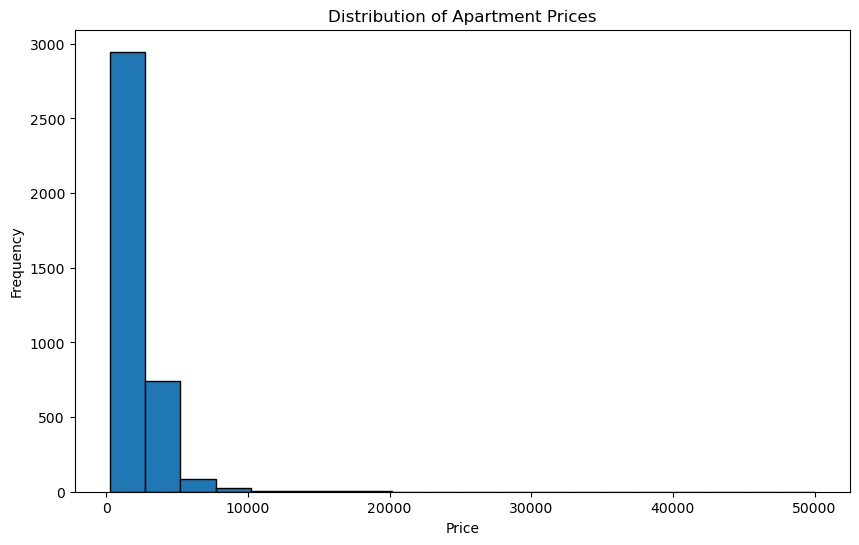

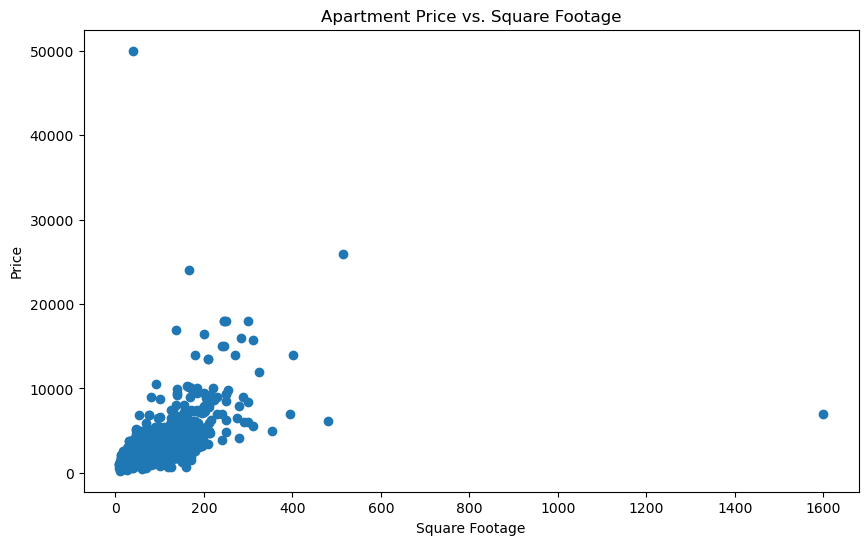

In [43]:
# Histogram of apartment prices
plt.figure(figsize=(10, 6))
plt.hist(final['price'], bins=20, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Apartment Prices')
plt.show()

# Scatter plot of apartment price vs. square footage
plt.figure(figsize=(10, 6))
plt.scatter(final['size'], final['price'])
plt.xlabel('Square Footage')
plt.ylabel('Price')
plt.title('Apartment Price vs. Square Footage')
plt.show()

# Correlation Matrix 

### How do we separate the data into training and testing data?

In [179]:
# Split the data into training and test sets (80% training, 20% testing)
train_df, test_df = train_test_split(final, test_size=0.2, random_state=42)


# Create the correlation matrix 
correlation_matrix = train_df.corr()

print(correlation_matrix)

                    id     rooms      size     price   zipcode  supermarkets
id            1.000000  0.058767  0.023215 -0.309592 -0.003458     -0.070651
rooms         0.058767  1.000000  0.707370  0.458676 -0.044220     -0.088965
size          0.023215  0.707370  1.000000  0.479788 -0.058077     -0.053999
price        -0.309592  0.458676  0.479788  1.000000 -0.036491     -0.177788
zipcode      -0.003458 -0.044220 -0.058077 -0.036491  1.000000      0.085625
supermarkets -0.070651 -0.088965 -0.053999 -0.177788  0.085625      1.000000


C:\Users\Snigis\AppData\Local\Temp\ipykernel_11100\3165822129.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


### Correlation Matrix Plot

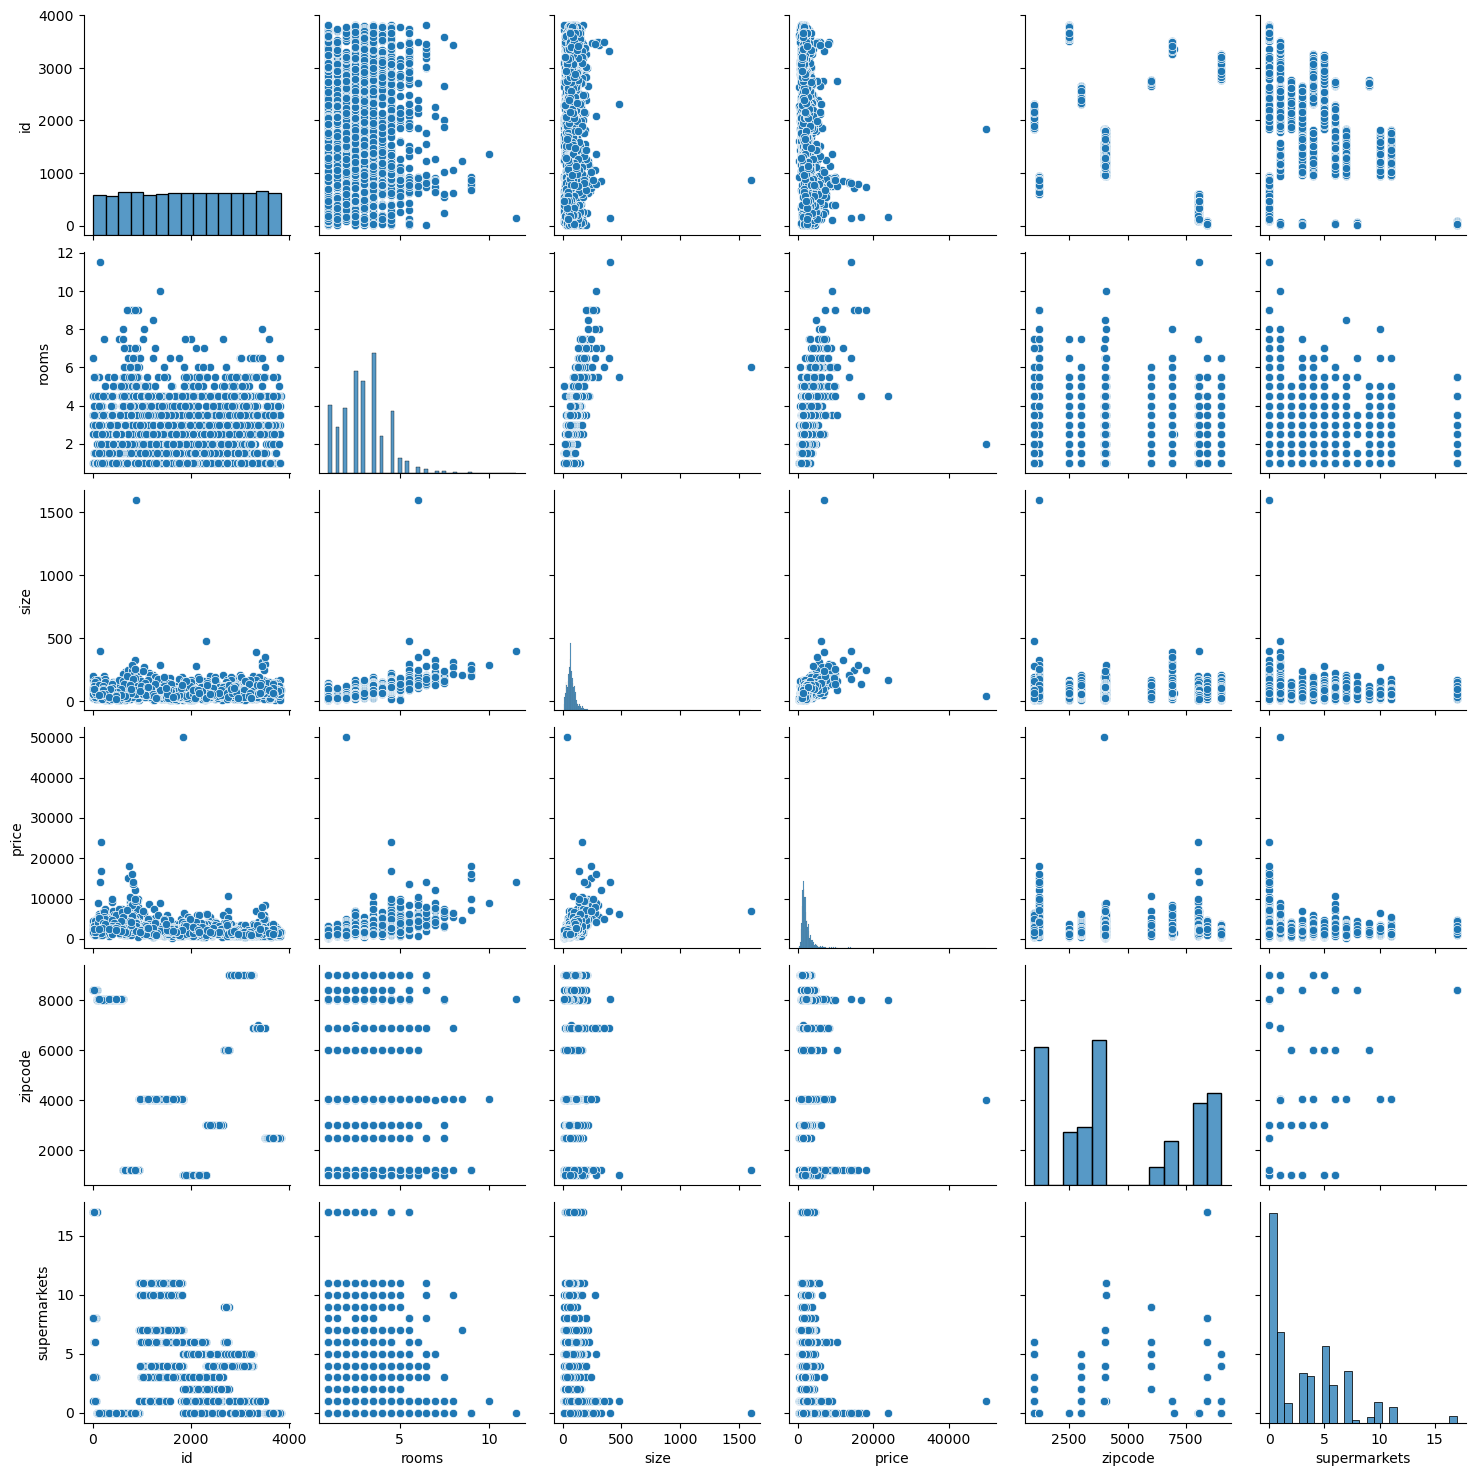

In [180]:
# Correlation Matrix Plot (corrplot)
sns.pairplot(train_df)

# normalization standardization

In [181]:
# Let us standardize training set, creating the so-called Z-scores.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_stand = (train_df - train_df_mean)/train_df_std

# Let us do the same for the test dataset
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_stand = (test_df - test_df_mean)/test_df_std

print("The data points have been standardized.")

The data points have been standardized.


C:\Users\Snigis\AppData\Local\Temp\ipykernel_11100\754321271.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df_mean = train_df.mean()
C:\Users\Snigis\AppData\Local\Temp\ipykernel_11100\754321271.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_df_std = train_df.std()
C:\Users\Snigis\AppData\Local\Temp\ipykernel_11100\754321271.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprec

# Linear Regression

In [182]:
# Create an empty list that will eventually hold all created feature columns.
# The target will be defined apart.
feature_columns = []

# We standardized all the columns, including latitude and longitude, into their
# Z-scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.


# Create a bucket feature column for latitude.
rooms_as_a_numeric_column = tf.feature_column.numeric_column("rooms")
rooms_boundaries = list(np.arange(int(min(train_df_stand['rooms'])), 
                                     int(max(train_df_stand['rooms'])), 
                                     resolution_in_Zs))
rooms = tf.feature_column.bucketized_column(rooms_as_a_numeric_column, rooms_boundaries)

# Create a bucket feature column for longitude.
size_as_a_numeric_column = tf.feature_column.numeric_column("size")
size_boundaries = list(np.arange(int(min(train_df_stand['size'])), 
                                      int(max(train_df_stand['size'])), 
                                      resolution_in_Zs))
size = tf.feature_column.bucketized_column(size_as_a_numeric_column, size_boundaries)

# Create a feature cross of latitude and longitude.
rooms_x_size = tf.feature_column.crossed_column([rooms, size], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(rooms_x_size)
feature_columns.append(crossed_feature)  

# Convert the list of feature columns into a layer that will later be fed into the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)


In [183]:
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, target_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.asarray(value).astype(np.float32) for name, value in dataset.items()}
  label = np.array(features.pop(target_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("The create_model and the train_model functions are set.")

The create_model and the train_model functions are set.


# Define the independent variables (features) and the dependent variable (price)
X = final[['rooms','size']]  # Example: Using square footage and number of bedrooms as features
y = final['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the linear regression model
model = keras.Sequential([
    keras.layers.Dense(1, input_shape=(2,))
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=100, verbose=1)

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f"Test set loss: {loss}")

# Make predictions using the trained model
predictions = model.predict(X_test_scaled)

# Plot the predicted prices vs. actual prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='Ideal')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

# Loss function

In [184]:
def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.05])
  plt.show()  

print("The plot_the_loss_curve function is correctly defined.")

The plot_the_loss_curve function is correctly defined.


In [185]:
print(train_df_stand.dtypes)


address          object
city             object
id              float64
kanton           object
price           float64
rooms           float64
size            float64
supermarkets    float64
zipcode         float64
dtype: object


Epoch 1/500
11/11 [==============================] - 0s 1ms/step - loss: 0.9908 - mean_squared_error: 0.9908
Epoch 2/500
11/11 [==============================] - 0s 2ms/step - loss: 0.9380 - mean_squared_error: 0.9380
Epoch 3/500
11/11 [==============================] - 0s 1ms/step - loss: 0.9068 - mean_squared_error: 0.9068
Epoch 4/500
11/11 [==============================] - 0s 1ms/step - loss: 0.8840 - mean_squared_error: 0.8840
Epoch 5/500
11/11 [==============================] - 0s 1ms/step - loss: 0.8676 - mean_squared_error: 0.8676
Epoch 6/500
11/11 [==============================] - 0s 1ms/step - loss: 0.8544 - mean_squared_error: 0.8544
Epoch 7/500
11/11 [==============================] - 0s 1ms/step - loss: 0.8444 - mean_squared_error: 0.8444
Epoch 8/500
11/11 [==============================] - 0s 1ms/step - loss: 0.8369 - mean_squared_error: 0.8369
Epoch 9/500
11/11 [==============================] - 0s 2ms/step - loss: 0.8306 - mean_squared_error: 0.8306
Epoch 10/500
11/11 

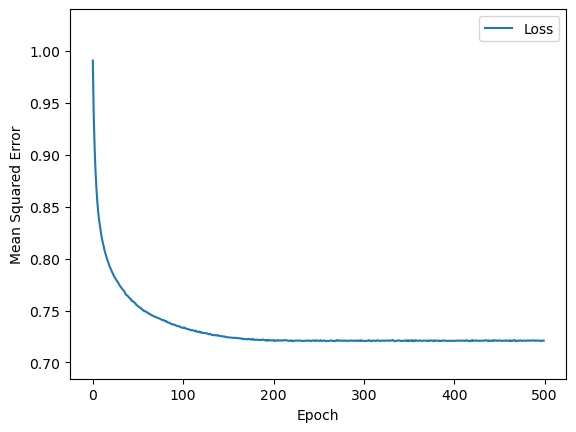


 Evaluate the linear regression model against the test set:
3/3 [==============================] - 0s 2ms/step - loss: 0.7562 - mean_squared_error: 0.7562


[0.7562060356140137, 0.7562060356140137]

In [186]:
# The following variables are the hyperparameters.
learning_rate = 0.01 # Always tune it w.r.t. the batch size.
                     # Small batch sizes require small learning rates.
                     # The learning rate is the most important hyperparameter. 
                     # If you have time to tune only one hyperparameter, then 
                     # tune the learning rate.
                     # Standard starting points are 0.01, 0.05 and 0.1.
epochs = 500  # You can use about 2 or 3 times the number of features (more than 
             # 100 only for very complex and large datasets). Increase if the
             # network still shows improvements for larger epochs.
batch_size = 300 # you can also use powers of 2 for larger networks.

# Here we define the target.
target_name = "price"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_stand, epochs, batch_size, target_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.asarray(value).astype(np.float32) for name, value in test_df_stand.items()}
test_label = np.array(test_features.pop(target_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

# NN

In [187]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple network."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer.
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit, 
  #     relu, here).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 10 nodes (i.e., 20/2). 
  model.add(tf.keras.layers.Dense(units=10, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [188]:
def train_model(model, dataset, epochs, target_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.asarray(value).astype(np.float32) for name, value in dataset.items()}
  label = np.array(features.pop(target_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

Epoch 1/100
16/16 [==============================] - 0s 2ms/step - loss: 0.9334 - mean_squared_error: 0.9334
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.8412 - mean_squared_error: 0.8412
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.8079 - mean_squared_error: 0.8079
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.7868 - mean_squared_error: 0.7868
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.7712 - mean_squared_error: 0.7712
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.7611 - mean_squared_error: 0.7611
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.7550 - mean_squared_error: 0.7550
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.7520 - mean_squared_error: 0.7520
Epoch 9/100
16/16 [==============================] - 0s 1ms/step - loss: 0.7442 - mean_squared_error: 0.7442
Epoch 10/100
16/16 

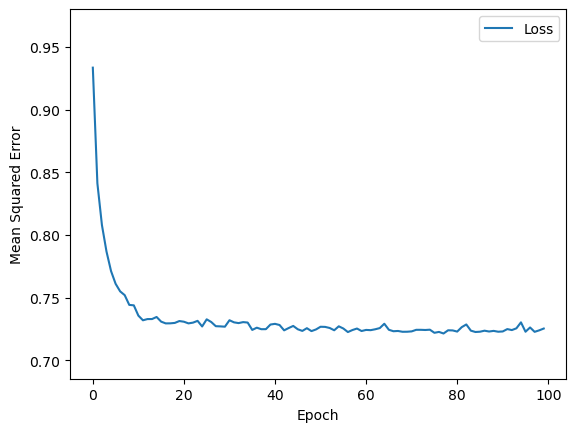


 Evaluate the new model against the test set:
4/4 [==============================] - 0s 2ms/step - loss: 0.7855 - mean_squared_error: 0.7855


[0.7855163216590881, 0.7855163216590881]

In [193]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 100
batch_size = 200

# Recall:
# The batch size is a hyperparameter that controls the number of training 
# samples to work through before the model’s internal parameters are updated.
# The number of epochs is a hyperparameter that controls the number of complete 
# passes through the training dataset.

# Specify the label
target_name = "price"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the standardized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_stand, epochs, 
                          target_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.asarray(value).astype(np.float32) for name, value in test_df_stand.items()}
test_target = np.array(test_features.pop(target_name)) # isolate the target
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_target, batch_size=batch_size)

# Comparison

# Regularization